# 1) Processing the dataset

### TESS Dataset: Toronto Emotional Speech Set

##### Contains 7 emotions - two actors of different biological gender with 200 files each 


7 x 2 x 200 = 2800 files in total


In [1]:
## Audio libraries (install if needed)

import noisereduce as nr # for noise reduction
import librosa # for feature extraction
import pydub # for normalising audio

Each folder is named either OAF or YAF depending on gender, followed by the emotion described, eg. 'OAF_angry'

The emotions are: neutral, happiness, sadness, anger, fear, disgust, pleasant surprise

Each file will be preprocessed and normalized.

### 1a: Analyzing and preprocessing a single audio file

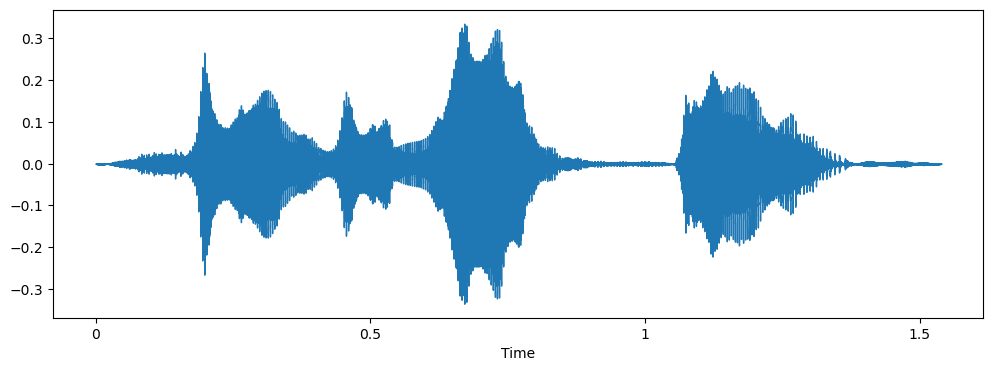

In [66]:
import os
import numpy as np
import time

cwd = os.getcwd()
path = cwd + '\dataset\TESS\OAF_angry\OAF_back_angry.wav'

from pydub import AudioSegment
#https://stackoverflow.com/questions/42492246/how-to-normalize-the-volume-of-an-audio-file-in-python

audio = AudioSegment.from_file(path)

import matplotlib.pyplot as plt
import librosa.display

y, sr = librosa.load(path)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)


The audio goes from roughly from -0.3 to 0.3 in terms of amplitude (in librosa units, which is between -1 and 1), so they are rather low. Furthermore, audio amplitudes are likely to be varying from one file to another. Let's have a look at a couple more:



[35647, 34002, 35432, 30764, 34093, 31546]

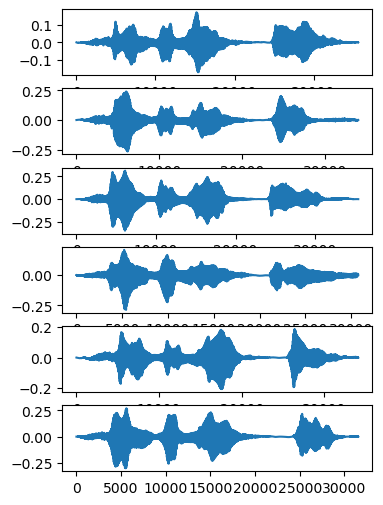

In [3]:
word_list = ['bar', 'base', 'bath', 'bean', 'beg', 'bite']
shapes = []
fig, axes = plt.subplots(6, 1, figsize=(4, 6))

for i in range(6):
    word = word_list[i]
    p = cwd + '\dataset\TESS\OAF_angry\OAF_'+word+'_angry.wav'
    y, sr = librosa.load(p)
    axes[i].plot(y)
    shapes.append(len(y))
shapes
    

We notice discrepancies both in amplitude, and in length of the audio files. These both need to be normalized before we move on to the next step.

C:\Users\kawai\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Pass orig_sr=24414, target_sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  import sys


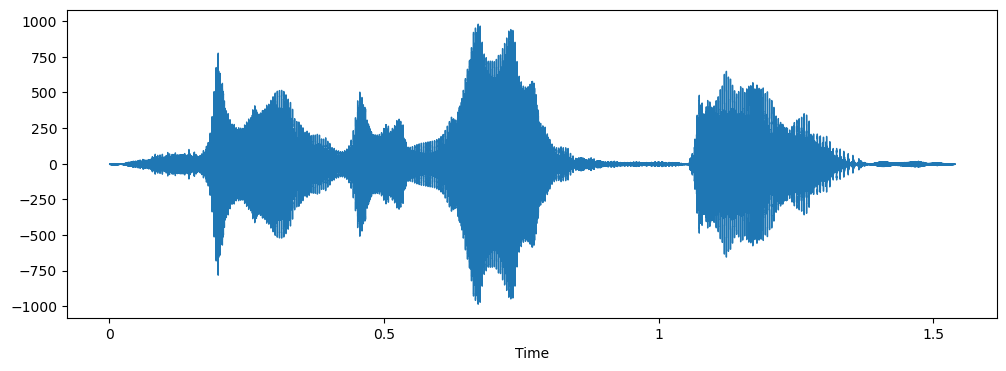

In [4]:
from pydub import effects

norm = effects.normalize(audio)

#convert from audiosegment, to a librosa sample (array of amplitudes)
normalized = np.array(norm.get_array_of_samples(), dtype = 'float32')/32768*1000
normalized = librosa.core.resample(normalized, norm.frame_rate, 22050, res_type='kaiser_best') 

plt.figure(figsize=(12, 4))
librosa.display.waveshow(normalized, sr=sr)

# Audio now normalized in volume, between 1000 to -1000, now we normalize the length

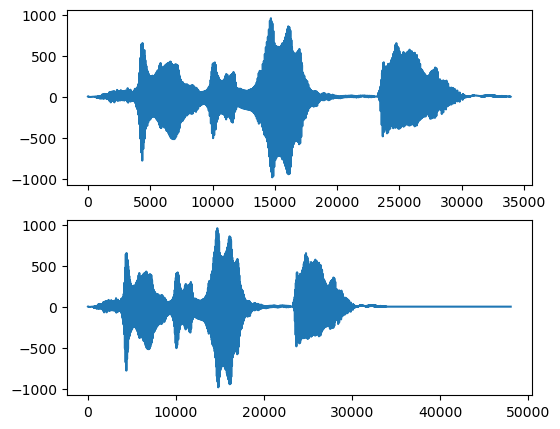

In [5]:
max_length = 48000 #for now

# Normalize length by padding values up to max length

full_normalized = np.pad(normalized, (0, max_length - len(normalized)),)

fig, axes = plt.subplots(2, 1, figsize=(6, 5))

axes[0].plot(normalized)
axes[1].plot(full_normalized)

Although every TESS file is very professionally recorded and likely contains no noise, there is no harm in adding noise reduction either way.


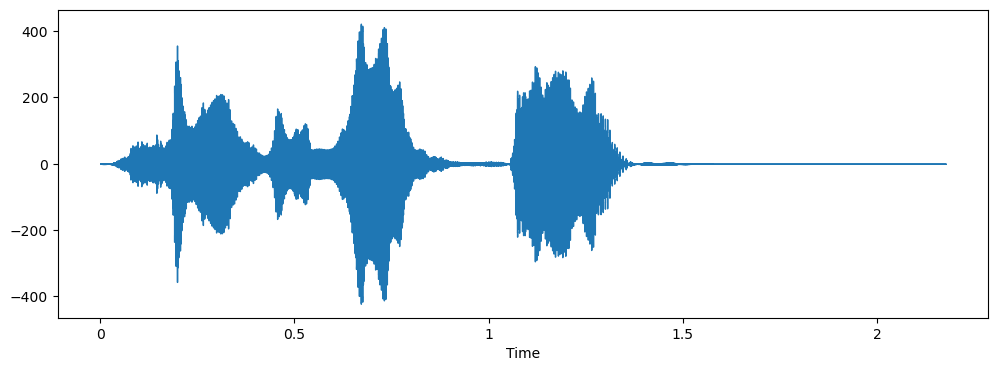

In [6]:
fin = nr.reduce_noise(full_normalized, sr=sr,)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(fin, sr=sr)

# Lowers the amplitude and doesnt do much...?

Now that we have analyzed the waveforms for preprocessing data, let's also have a look at the spectograms, as they might be easier to work with than raw audio

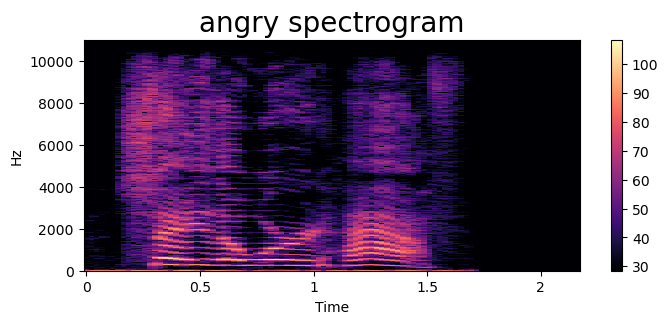

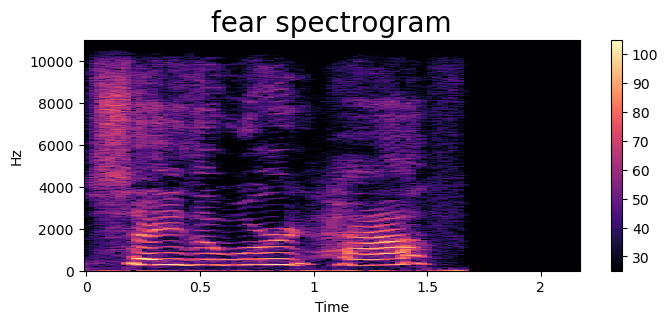

In [7]:
angry = cwd + '\dataset\TESS\OAF_angry\OAF_half_angry.wav'
fear = cwd + '\dataset\TESS\OAF_fear\OAF_half_fear.wav'

y_angry, sr_a = librosa.load(angry)
y_fear, sr_f = librosa.load(fear)

audio_angry = effects.normalize(AudioSegment.from_file(angry))

# I should probably define a preprocessing function.
ya = (np.array(audio_angry.get_array_of_samples(), dtype = 'float32')/32768*1000)
ya = librosa.core.resample(ya, orig_sr=audio_angry.frame_rate, target_sr=22050, res_type='kaiser_best') 
ya = np.pad(ya, (0, max_length - len(ya)),)
# will skip noise reduce for now.

audio_fear = effects.normalize(AudioSegment.from_file(fear))

yf = (np.array(audio_fear.get_array_of_samples(), dtype = 'float32')/32768*1000)
yf = librosa.core.resample(yf, orig_sr=audio_fear.frame_rate, target_sr=22050, res_type='kaiser_best') 
yf = np.pad(yf, (0, max_length - len(yf)),)

xa = librosa.stft(ya)
xa_db = librosa.amplitude_to_db(abs(xa)) # Spectrogram 
plt.figure(figsize=(8,3))
plt.title('angry spectrogram', size=20)
librosa.display.specshow(xa_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

xf = librosa.stft(yf)
xf_db = librosa.amplitude_to_db(abs(xf)) 
plt.figure(figsize=(8,3))
plt.title('fear spectrogram', size=20)
librosa.display.specshow(xf_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

Now let's check out the chromagrams

C:\Users\kawai\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=750
  return f(*args, **kwargs)


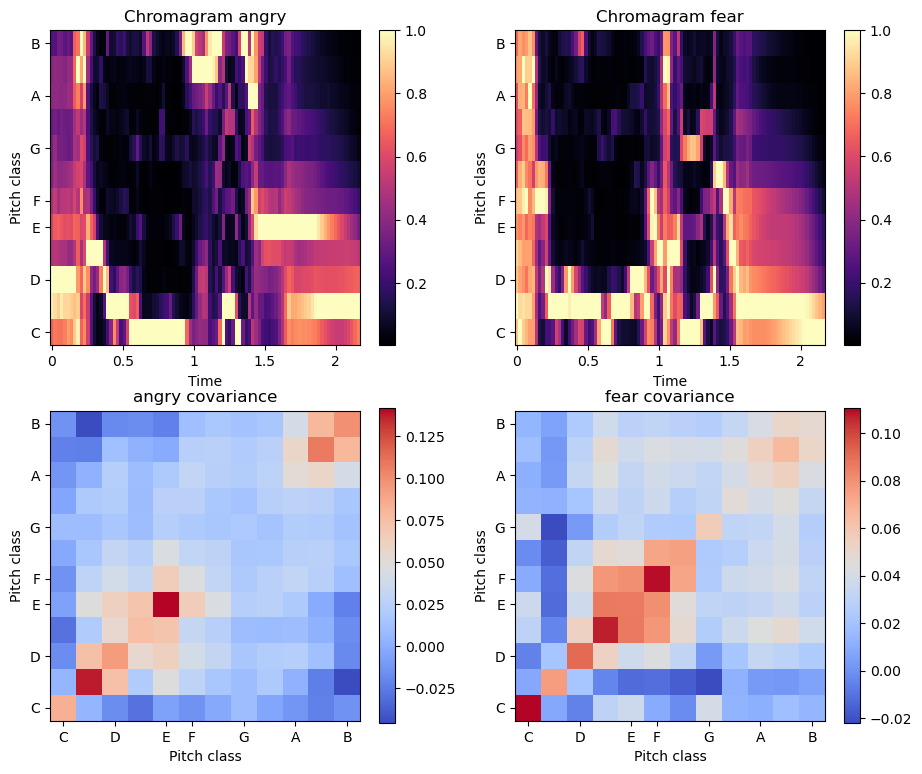

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(11, 9))

chroma = librosa.feature.chroma_cqt(y=ya, sr=sr)
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[0][0])
ax[0,0].set(title='Chromagram angry')
fig.colorbar(img, ax=ax[0,0])

chroma_f = librosa.feature.chroma_cqt(y=yf, sr=sr)
img2 = librosa.display.specshow(chroma_f, y_axis='chroma', x_axis='time', ax=ax[0][1])
ax[0,1].set(title='Chromagram fear')
fig.colorbar(img2, ax=ax[0,1])

angry_cov = np.cov(chroma)
img3 = librosa.display.specshow(angry_cov, y_axis='chroma', x_axis='chroma', ax=ax[1,0])
ax[1,0].set(title='angry covariance')
fig.colorbar(img3, ax=ax[1,0])

fear_cov = np.cov(chroma_f)
img4 = librosa.display.specshow(fear_cov, y_axis='chroma', x_axis='chroma', ax=ax[1,1])
ax[1,1].set(title='fear covariance')
fig.colorbar(img4, ax=ax[1,1])

Chromagrams show a quite clear distinction between the fear and angry, suggesting this will be a good feature to extract.

### Feature extraction for a base model

Librosa offers a variety of features to be extracted. For now I selected 5.

https://librosa.org/doc/main/feature.html

I will extract the following features:

1) MFCC - Mel-Frequency Cepstral Coefficients - short-term power spectrum of a sound

2) Chroma - different pitch classes

3) RMS - Root Mean Square - energy

4) ZCR - Zero Crossing Rate

Parameters (provisional):


'frame_length': tends to be around 20-40ms. Needs to be divisible by hop length. With frame length 800 we will have roughly 27ms frames

http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

'hop_length' needs to be same for all of them to ensure compatible rates. Since the length of each file is 48000, with hop_length= 200 we will have arrays with 305 samples.

'n_mfcc' set to 20 for now.



In [9]:

hl = 200


mfcc = librosa.feature.mfcc(y=fin, sr=sr, S=None, n_mfcc=20,hop_length=hl)
print('MFCC: ',(mfcc.shape))

chroma = librosa.feature.chroma_stft(y=fin, sr=sr,hop_length=hl)
print('Chroma: ',(chroma.shape))

rms = librosa.feature.rms(y=fin,hop_length=hl) 
print('RMS shape:', rms.shape)

zcr = librosa.feature.zero_crossing_rate(y=fin, hop_length=hl)
print('ZCR shape: ', zcr.shape)


MFCC:  (20, 241)
Chroma:  (12, 241)
RMS shape: (1, 241)
ZCR shape:  (1, 241)


## Diagram describing audio processing and feature extraction

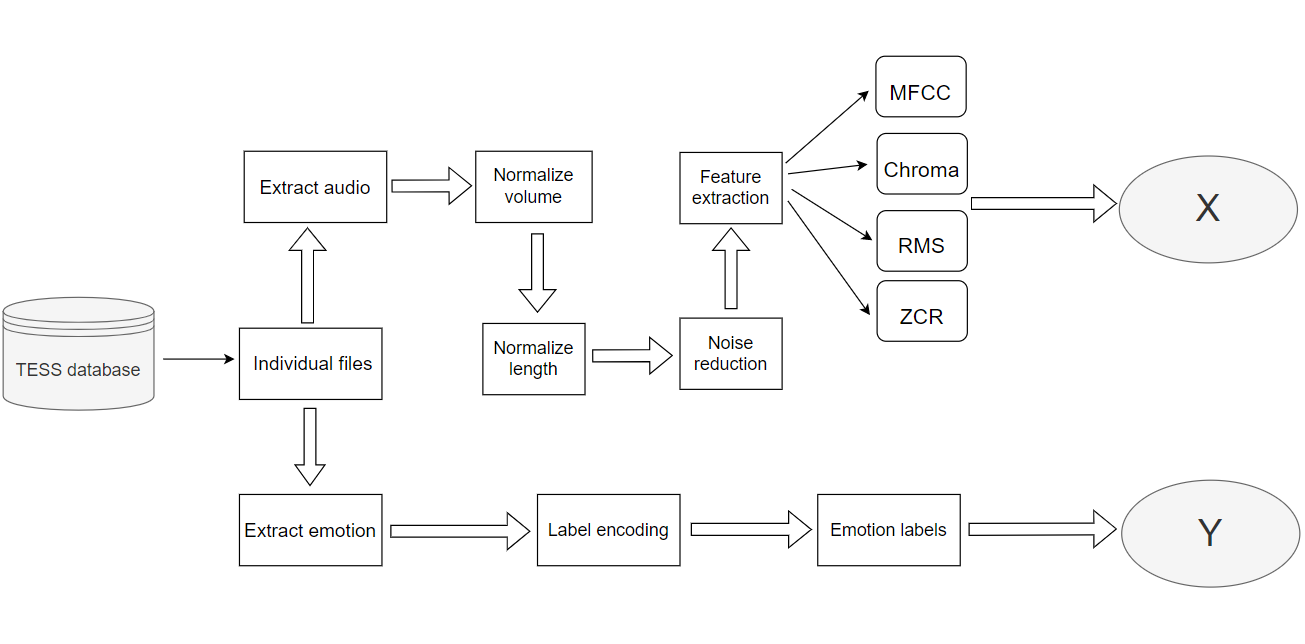

### 1b: Processing all the files (no feature extraction)


In [10]:
# Let's get rid of the temporary variable max_len by calculating the real value:

database = cwd + '\dataset\TESS'
current = ''
max_len = 0

for subdir, dirs, files in os.walk(database):
    for file in files: 
        x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
        if len(x) > max_len:
            current = file
            max_len = len(x)
            
print(max_len)

145172


In [11]:
# 145172 thats a lor larger than I expected but alright then. Doesn't really have any factors though, so we will do 145180
# Now that we know the max_len, we can iterate over all the files and preprocess them (without feature extraction)

import pandas as pd
import time

# Will create one for raw audio, one for spectrograms.

max_len = 145180
labels = []
audios = []
spectrograms = []

start = time.perf_counter()

for subdir, dirs, files in os.walk(database):
    for file in files: 
        # Preprocessing
        emotion = str(file[:-4].split('_')[-1])
        
        y, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
        audio = AudioSegment.from_file(os.path.join(subdir,file)) 
    
        normalized = effects.normalize(audio)
        full_normalized = (np.array(audio.get_array_of_samples(), dtype = 'float32')/32768*1000)
        full_normalized = librosa.core.resample(full_normalized, orig_sr=audio_angry.frame_rate, target_sr=22050, res_type='kaiser_best') 
        full_normalized = np.pad(full_normalized, (0, max_len - len(full_normalized)),)
        fin = nr.reduce_noise(full_normalized, sr=sr,)
        
        # Create spectrogram:
        stft_fin = librosa.stft(fin)
        spectrogram = librosa.amplitude_to_db(abs(stft_fin)) 
        
        labels.append(emotion)
        audios.append(fin)
        spectrograms.append(spectrogram)

end = time.perf_counter()
print(f"Total time taken: {(end - start)/60:0.3f} minutes")


Total time taken: 7.560 minutes


Probably need to save the data, as running the script everytime would take too much time.

# 2) Base models

### Feature extraction 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mfccs=[]
chroma=[]
rms=[]
zcr=[]

hl=610

for fin in audios:
    mfcc = librosa.feature.mfcc(y=fin, sr=sr, S=None, n_mfcc=20,hop_length=hl)
    chrom = librosa.feature.chroma_stft(y=fin, sr=sr,hop_length=hl)
    rms1 = librosa.feature.rms(y=fin,hop_length=hl) 
    zcr1 = librosa.feature.zero_crossing_rate(y=fin, hop_length=hl)
    
    mfccs.append(mfcc)
    chroma.append(chrom)
    rms.append(rms1)
    zcr.append(zcr1)


In [13]:
# Need to be concatenated into a single numpy array - have to alter shapes a bit.
# Right now, they should all be 2800/X/239

np.asarray(chroma).shape

# We want 2800/239/X to concatenate into together into 2800/239/34

(2800, 12, 239)

In [14]:
mfcc_arr = np.swapaxes(np.asarray(mfccs).astype('float32'), 1, 2)
chroma_arr = np.swapaxes(np.asarray(chroma).astype('float32'), 1, 2)
rms_arr = np.swapaxes(np.asarray(rms).astype('float32'), 1, 2)
zcr_arr = np.swapaxes(np.asarray(zcr).astype('float32'), 1, 2)

X = np.concatenate((mfcc_arr, chroma_arr, rms_arr, zcr_arr), axis=2)
X.shape

(2800, 239, 34)

In [15]:
# Now labels:

Y = np.asarray(labels)
Y.shape

(2800,)

In [16]:
# Split into train/test
import tensorflow as tf
import keras

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

X_test.shape

(700, 239, 34)

In [17]:
# Initialize model: MLP for now, but likely will change to whichever neural network I choose for the end-to-end
# Some base params (likely won't be tuned)

Xb_train = X_train.reshape((2100, 239*34))
Xb_test = X_test.reshape((700, 239*34))

model = MLPClassifier(alpha=0.01, hidden_layer_sizes=(100,), learning_rate='adaptive', max_iter=400)
model.fit(Xb_train, y_train)

MLPClassifier(alpha=0.01, learning_rate='adaptive', max_iter=400)

In [18]:
y_pred = model.predict(Xb_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the base model is: {:.1f}%".format(accuracy*100))


Accuracy of the base model is: 97.6%


In [19]:
y_pred[y_pred!=y_test]

array(['angry', 'disgust', 'ps', 'sad', 'ps', 'ps', 'fear', 'angry', 'ps',
       'sad', 'neutral', 'sad', 'disgust', 'happy', 'angry', 'happy',
       'angry'], dtype='<U7')

681 out of 700 were predicted correctly. This leads me to believe that the model is overfitted to our data set and might not do so well with data from a different database. 

I might select another set of data and try to get the model to predict that. Do other models also do this well?

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

dtc = DecisionTreeClassifier(max_depth=15)
svm = SVC(kernel="linear", C=0.05)
rfc = RandomForestClassifier(max_depth=15, n_estimators=25, max_features=5)

dtc.fit(Xb_train, y_train)
dtc_pred = dtc.predict(Xb_test)
acc = accuracy_score(y_true=y_test, y_pred=dtc_pred)
print("Accuracy of the Decision Tree Classifier model is: {:.1f}%".format(acc*100))

svm.fit(Xb_train, y_train)
svm_pred = svm.predict(Xb_test)
acc2 = accuracy_score(y_true=y_test, y_pred=svm_pred)
print("Accuracy of the Linear SVM model is: {:.1f}%".format(acc2*100))

rfc.fit(Xb_train, y_train)
rfc_pred = rfc.predict(Xb_test)
acc3 = accuracy_score(y_true=y_test, y_pred=rfc_pred)
print("Accuracy of the Decision Tree Classifier model is: {:.1f}%".format(acc3*100))

Accuracy of the Decision Tree Classifier model is: 85.0%
Accuracy of the Linear SVM model is: 99.9%
Accuracy of the Decision Tree Classifier model is: 94.3%


# 3) New dataset

The TESS dataset is likely too simple to classify on - there is no noise, professional recordings, the basic models do a very good job themselves and there is no need for a Deep Learning model

I will for this reason choose a more complicated dataset: MSP-IMPROV

Resources:

https://ecs.utdallas.edu/research/researchlabs/msp-lab/publications/Busso_2017.pdf \
https://ecs.utdallas.edu/research/researchlabs/msp-lab/MSP-Improv.html

The dataset is divided into sessions folders, for now I will have a look at just one session folder to see what is happening.

There are 4 emotions - Angry, Sad, Happy, Neutral. The audio files are sorted by the intended emotion of speech (there is also an evaluated emotion of speech, however for now I will go with the intended one, as it is much simpler to work with), with each session having 20 target sentences repeated in 4 emotions. However it is not as simple as the TESS dataset, there are two iterations for each of the target sentences, one where it is read outloud as a single sentence and another when the actors act out an improvised scenario, during which the target sentence is used. For now, both will be used.

For more clarification and information about the naming of the files, please read [here](http://www.lab-msp.com/MSP-IMPROV/Readme.txt).

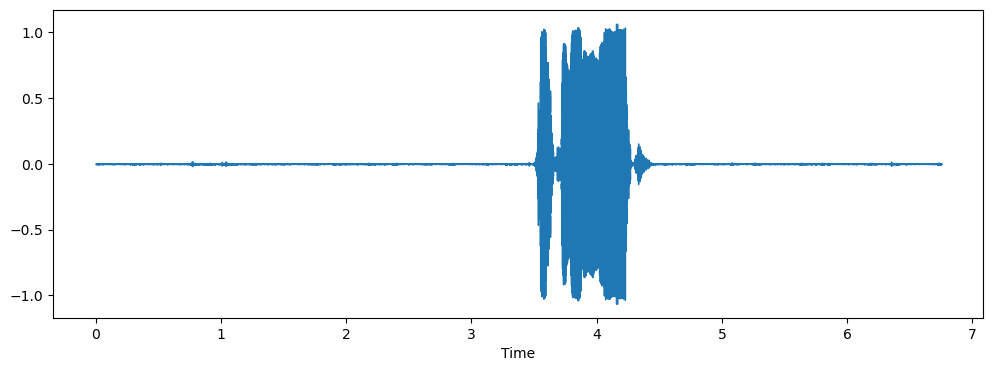

In [21]:
import os
import numpy as np
import time

cwd = os.getcwd()
path = cwd + '\dataset\MSP-IMPROV\session1\session1\S01A\R\MSP-IMPROV-S01A-M01-R-MM01.wav'

from pydub import AudioSegment

audio = AudioSegment.from_file(path)

import matplotlib.pyplot as plt
import librosa.display

y, sr = librosa.load(path)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
audio

   A lot more silence and the actual speech only goes from like 3.5s to 4.5s, so the edges might have to get trimmed, let's see what we can do here. Let's first normalize it by volume, and then see if we can cut the silent edges.

In [22]:
def vol_normalize(audio):
    norm = effects.normalize(audio)
    #convert from audiosegment, to a librosa sample (array of amplitudes)
    normalized = np.array(norm.get_array_of_samples(), dtype = 'float32')/32768*1000
    
    normalized = librosa.core.resample(normalized, orig_sr=norm.frame_rate, target_sr=22050, res_type='kaiser_best') 
    return normalized

(19840,)

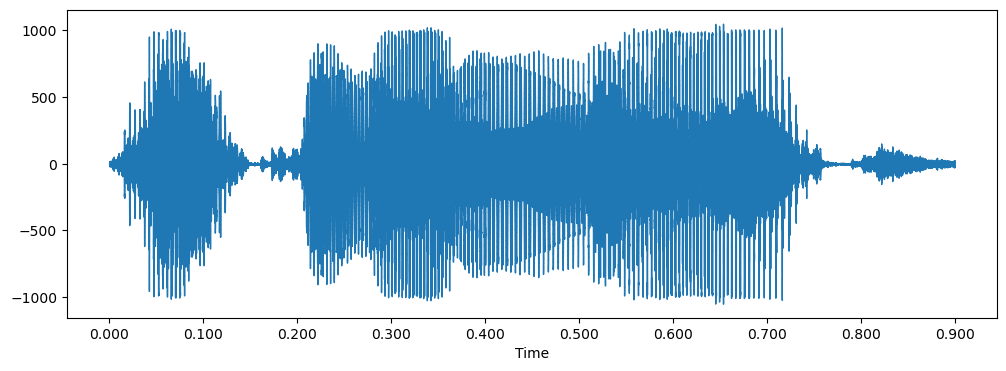

In [23]:
norm = vol_normalize(audio)

trim, ix = librosa.effects.trim(norm, top_db=32,frame_length=256, hop_length=64)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(trim, sr=sr)

trim.shape

In [24]:
from IPython.display import Audio

Audio(data=trim, rate=sr)

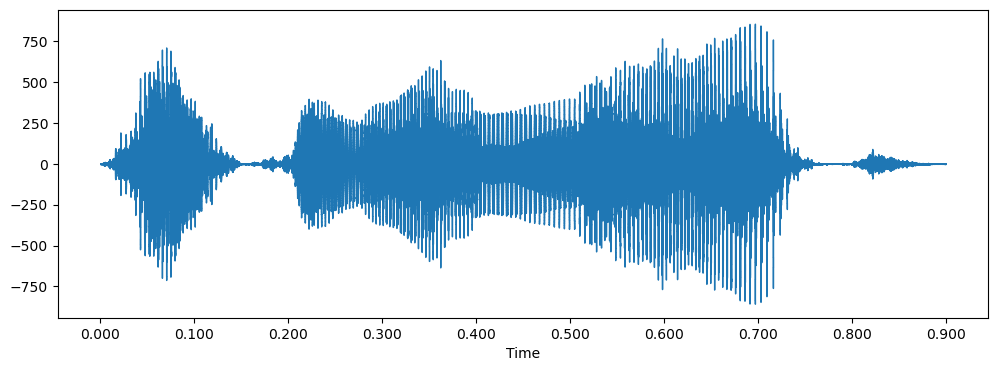

In [25]:
fin = nr.reduce_noise(trim, sr=sr,)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(fin, sr=sr)
Audio(data=fin, rate=sr)

Alright, processing again, this time a little less simple though, since the emotion isnt the folder name exactly + we are trimming the edges of the audio files

In [26]:
database = cwd + '\dataset\MSP-IMPROV'
current = ''
max_len = 0

for subdir, dirs, files in os.walk(database):
    for file in files: 
        type = file.split('-')[-2] #Get the type of recording, some are not really usable (i.e. P is just instructions)
        if type in ['R', 'T']:
            x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
            trim, ix = librosa.effects.trim(x, top_db=32,frame_length=256, hop_length=64)
            if len(trim) > max_len:
                current = os.path.join(subdir,file)
                max_len = len(trim)
print(max_len)
current

567424


'C:\\Users\\kawai\\~L4 Project\\dataset\\MSP-IMPROV\\session3\\session3\\S20S\\R\\MSP-IMPROV-S20S-F03-R-FF02.wav'

That is a lot longer than I expected, let us inspect this file

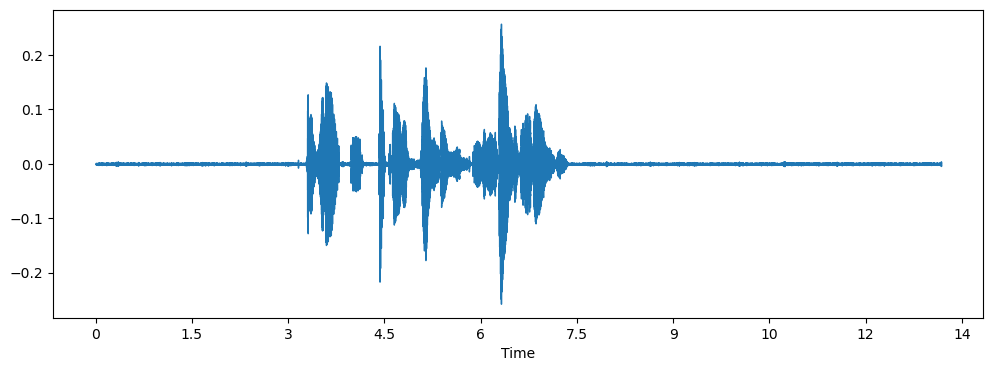

In [27]:
path = current

audio = AudioSegment.from_file(path)
x, sr = librosa.load(path, sr=None)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(x, sr=sr)
audio

So it is probably not getting correctly trimmed, since theres a lot of silences...

In [28]:
print(y.shape)

(148874,)


In [29]:
trim, ix = librosa.effects.trim(x, top_db=25,frame_length=256, hop_length=64)
trim.shape

#trimming adds length???

(176512,)

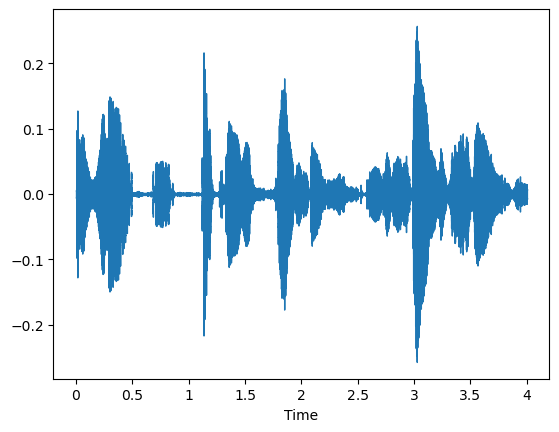

In [30]:
librosa.display.waveshow(trim, sr=sr)

In [31]:
Audio(data=trim, rate=sr)

Had to play around a bit with the boundaries of the trim, but top db at 25 seems to do the trick well, here it is:

max length is:  338368


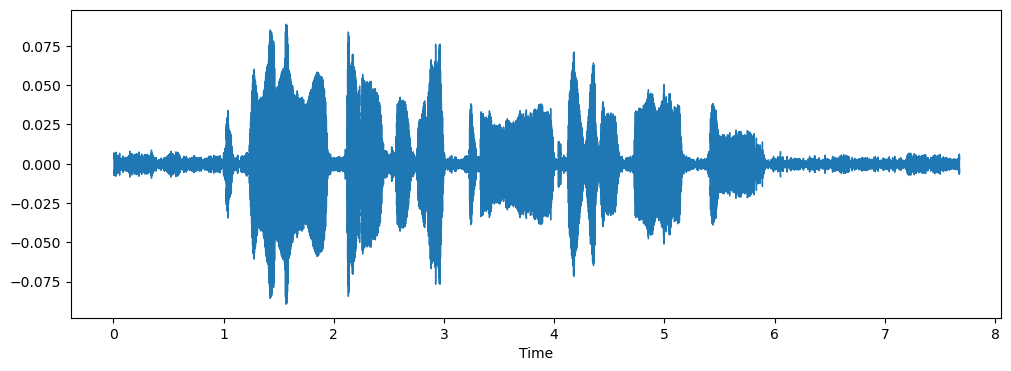

In [32]:
database = cwd + '\dataset\MSP-IMPROV'
current = ''
max_len = 0

for subdir, dirs, files in os.walk(database):
    for file in files: 
        type = file.split('-')[-2] #Get the type of recording, some are not really usable (i.e. P is just instructions)
        if type in ['R', 'T']:
            x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
            trim, ix = librosa.effects.trim(x, top_db=25,frame_length=256, hop_length=64)
            if len(trim) > max_len:
                current = os.path.join(subdir,file)
                max_len = len(trim)
                
print('max length is: ', max_len)

path = current

audio = AudioSegment.from_file(path)
x, sr = librosa.load(path, sr=None)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(x, sr=sr)
audio

In [33]:
# Processing all data now:

labels = []
audios = []
spectrograms = []
emotions = {'S':'sad', 'A': 'angry', 'N':'neutral', 'H':'happy'}

start = time.perf_counter()

for subdir, dirs, files in os.walk(database):
    for file in files: 
        # Preprocessing
        process = file.split('-')[-2]
        if process in ['R', 'T']:
            
            y, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
            audio = AudioSegment.from_file(os.path.join(subdir,file)) 

            normalized = effects.normalize(audio)
            full_normalized = (np.array(audio.get_array_of_samples(), dtype = 'float32')/32768*1000)
            full_normalized = librosa.core.resample(full_normalized, orig_sr=audio_angry.frame_rate, target_sr=22050, res_type='kaiser_best')
            trim, ix = librosa.effects.trim(full_normalized, top_db=25,frame_length=256, hop_length=64)
            full_normalized = np.pad(trim, (0, max_len - len(trim)),)
            fin = nr.reduce_noise(full_normalized, sr=sr,)

            # Create spectrogram:
            stft_fin = librosa.stft(fin)
            spectrogram = librosa.amplitude_to_db(abs(stft_fin)) 
            
            emotion = emotions[file.split('\\')[-1].split('-')[2][-1]]
            labels.append(emotion)
            audios.append(fin)
            spectrograms.append(spectrogram)

end = time.perf_counter()
print(f"Total time taken: {(end - start)/60:0.3f} minutes")

Total time taken: 9.141 minutes


In [34]:
# Let's try some feature extraction and base models
labels[:5]

['angry', 'angry', 'angry', 'happy', 'happy']

In [35]:
# Feature extraction

mfccs=[]
chroma=[]
rms=[]
zcr=[]
#338368 is divisible by 544
hl=544

for fin in audios:
    mfcc = librosa.feature.mfcc(y=fin, sr=sr, S=None, n_mfcc=20,hop_length=hl)
    chrom = librosa.feature.chroma_stft(y=fin, sr=sr,hop_length=hl)
    rms1 = librosa.feature.rms(y=fin,hop_length=hl) 
    zcr1 = librosa.feature.zero_crossing_rate(y=fin, hop_length=hl)
    
    mfccs.append(mfcc)
    chroma.append(chrom)
    rms.append(rms1)
    zcr.append(zcr1)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mfcc_arr = np.swapaxes(np.asarray(mfccs).astype('float32'), 1, 2)
chroma_arr = np.swapaxes(np.asarray(chroma).astype('float32'), 1, 2)
rms_arr = np.swapaxes(np.asarray(rms).astype('float32'), 1, 2)
zcr_arr = np.swapaxes(np.asarray(zcr).astype('float32'), 1, 2)

X = np.concatenate((mfcc_arr, chroma_arr, rms_arr, zcr_arr), axis=2)
Y = np.asarray(labels)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

X_train.shape

(954, 623, 34)

In [39]:
Xb_train = X_train.reshape((len(X_train), 623*34))
Xb_test = X_test.reshape((len(X_test), 623*34))

model = MLPClassifier(alpha=0.01, hidden_layer_sizes=(100,), learning_rate='adaptive', max_iter=400)
model.fit(Xb_train, y_train)

MLPClassifier(alpha=0.01, learning_rate='adaptive', max_iter=400)

In [40]:
y_pred = model.predict(Xb_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the base model is: {:.1f}%".format(accuracy*100))


Accuracy of the base model is: 41.5%


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

dtc = DecisionTreeClassifier(max_depth=15)
svm = SVC(kernel="linear", C=0.05)
rfc = RandomForestClassifier(max_depth=15, n_estimators=25, max_features=5)

dtc.fit(Xb_train, y_train)
dtc_pred = dtc.predict(Xb_test)
acc = accuracy_score(y_true=y_test, y_pred=dtc_pred)
print("Accuracy of the Decision Tree Classifier model is: {:.1f}%".format(acc*100))

svm.fit(Xb_train, y_train)
svm_pred = svm.predict(Xb_test)
acc2 = accuracy_score(y_true=y_test, y_pred=svm_pred)
print("Accuracy of the Linear SVM model is: {:.1f}%".format(acc2*100))

rfc.fit(Xb_train, y_train)
rfc_pred = rfc.predict(Xb_test)
acc3 = accuracy_score(y_true=y_test, y_pred=rfc_pred)
print("Accuracy of the Decision Tree Classifier model is: {:.1f}%".format(acc3*100))


Accuracy of the Decision Tree Classifier model is: 34.0%
Accuracy of the Linear SVM model is: 42.5%
Accuracy of the Decision Tree Classifier model is: 37.1%


In [42]:
svm2 = SVC()
svm2.fit(Xb_train, y_train)
svm2_pred = svm2.predict(Xb_test)
acc2 = accuracy_score(y_true=y_test, y_pred=svm2_pred)
print("Accuracy of the RBF SVM model is: {:.1f}%".format(acc2*100))

Accuracy of the RBF SVM model is: 45.6%


In [43]:
# 45 is def not good enough, lets do some cross validation and parameter tuning on SVM
# Cross validation: 

from sklearn.model_selection import cross_val_score
from sklearn import metrics

scores = cross_val_score(svm2, Xb_train, y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [44]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.42 accuracy with a standard deviation of 0.03


In [45]:
# Okay, lets do it with Grid Search and tune some parameters too
from sklearn.model_selection import GridSearchCV

param_grid= {'kernel': ('linear', 'rbf',),
             'C': [1, 10, 100],
            'gamma':('scale', 'auto')}
start = time.perf_counter()
clf = GridSearchCV(SVC(), param_grid, n_jobs = -1, verbose = 3,scoring='accuracy', cv = 5)
clf.fit(Xb_train, y_train)

print("Best parameters set found on development set: ", clf.best_params_)

end = time.perf_counter()
print(f"Total time taken: {(end - start)/60:0.3f} minutes")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters set found on development set:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Total time taken: 10.300 minutes


In [46]:
svm2 = SVC(C=10, gamma= 'scale', kernel='rbf')
svm2.fit(Xb_train, y_train)
svm2_pred = svm2.predict(Xb_test)
acc2 = accuracy_score(y_true=y_test, y_pred=svm2_pred)
print("Accuracy of the tuned SVM model is: {:.1f}%".format(acc2*100))

Accuracy of the tuned SVM model is: 41.8%


In [47]:
# Hmm... let's try something else ...
# No edge trimming because were padding silence anyway?

database = cwd + '\dataset\MSP-IMPROV'
current = ''
max_len = 0

for subdir, dirs, files in os.walk(database):
    for file in files: 
        type = file.split('-')[-2] #Get the type of recording, some are not really usable (i.e. P is just instructions)
        if type in ['R', 'T']:
            x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
            if len(x) > max_len:
                current = os.path.join(subdir,file)
                max_len = len(x)
                
print('max length is: ', max_len)


max length is:  598878


In [48]:
labels = []
audios = []
spectrograms = []
emotions = {'S':'sad', 'A': 'angry', 'N':'neutral', 'H':'happy'}

start = time.perf_counter()

for subdir, dirs, files in os.walk(database):
    for file in files: 
        # Preprocessing
        process = file.split('-')[-2]
        if process in ['R', 'T']:
            
            y, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
            audio = AudioSegment.from_file(os.path.join(subdir,file)) 

            normalized = effects.normalize(audio)
            full_normalized = (np.array(audio.get_array_of_samples(), dtype = 'float32')/32768*1000)
            full_normalized = librosa.core.resample(full_normalized, orig_sr=audio_angry.frame_rate, target_sr=22050, res_type='kaiser_best')
            full_normalized = np.pad(full_normalized, (0, max_len - len(full_normalized)),)
            fin = nr.reduce_noise(full_normalized, sr=sr,)

            # Create spectrogram:
            stft_fin = librosa.stft(fin)
            spectrogram = librosa.amplitude_to_db(abs(stft_fin)) 
            
            emotion = emotions[file.split('\\')[-1].split('-')[2][-1]]
            labels.append(emotion)
            audios.append(fin)
            spectrograms.append(spectrogram)

end = time.perf_counter()
print(f"Total time taken: {(end - start)/60:0.3f} minutes")

Total time taken: 10.341 minutes


In [49]:
mfccs=[]
chroma=[]
rms=[]
zcr=[]
#598878 is divisible by 873
hl=873

for fin in audios:
    mfcc = librosa.feature.mfcc(y=fin, sr=sr, S=None, n_mfcc=20,hop_length=hl)
    chrom = librosa.feature.chroma_stft(y=fin, sr=sr,hop_length=hl)
    rms1 = librosa.feature.rms(y=fin,hop_length=hl) 
    zcr1 = librosa.feature.zero_crossing_rate(y=fin, hop_length=hl)
    
    mfccs.append(mfcc)
    chroma.append(chrom)
    rms.append(rms1)
    zcr.append(zcr1)


In [50]:
len(mfccs)

1272

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mfcc_arr = np.swapaxes(np.asarray(mfccs).astype('float32'), 1, 2)
chroma_arr = np.swapaxes(np.asarray(chroma).astype('float32'), 1, 2)
rms_arr = np.swapaxes(np.asarray(rms).astype('float32'), 1, 2)
zcr_arr = np.swapaxes(np.asarray(zcr).astype('float32'), 1, 2)

X = np.concatenate((mfcc_arr, chroma_arr, rms_arr, zcr_arr), axis=2)
Y = np.asarray(labels)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

X_train.shape

(954, 687, 34)

In [52]:
Xb_train = X_train.reshape((len(X_train), 687*34))
Xb_test = X_test.reshape((len(X_test), 687*34))

model = MLPClassifier(alpha=0.01, hidden_layer_sizes=(100,), learning_rate='adaptive', max_iter=400)
model.fit(Xb_train, y_train)

MLPClassifier(alpha=0.01, learning_rate='adaptive', max_iter=400)

In [53]:
y_pred = model.predict(Xb_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the base model is: {:.1f}%".format(accuracy*100))


Accuracy of the base model is: 36.5%


In [54]:
dtc = DecisionTreeClassifier(max_depth=15)
svm = SVC(kernel="linear", C=0.05)
rfc = RandomForestClassifier(max_depth=15, n_estimators=25, max_features=5)

dtc.fit(Xb_train, y_train)
dtc_pred = dtc.predict(Xb_test)
acc = accuracy_score(y_true=y_test, y_pred=dtc_pred)
print("Accuracy of the Decision Tree Classifier model is: {:.1f}%".format(acc*100))

svm.fit(Xb_train, y_train)
svm_pred = svm.predict(Xb_test)
acc2 = accuracy_score(y_true=y_test, y_pred=svm_pred)
print("Accuracy of the Linear SVM model is: {:.1f}%".format(acc2*100))

rfc.fit(Xb_train, y_train)
rfc_pred = rfc.predict(Xb_test)
acc3 = accuracy_score(y_true=y_test, y_pred=rfc_pred)
print("Accuracy of the Decision Tree Classifier model is: {:.1f}%".format(acc3*100))

Accuracy of the Decision Tree Classifier model is: 35.8%
Accuracy of the Linear SVM model is: 38.1%
Accuracy of the Decision Tree Classifier model is: 39.0%


In [105]:
labels = []
audios = []
spectrograms = []
emotions = {'S':'sad', 'A': 'angry', 'N':'neutral', 'H':'happy', 'X':'X', 'O': 'other'}
max_len = 338368
start = time.perf_counter()


pat = cwd + '\dataset\Evalution.txt'
with open(pat) as f:
    contents = f.read()
    lines = contents.split(';')

for subdir, dirs, files in os.walk(database):
    for file in files: 
        # Preprocessing
        process = file.split('-')[-2]
        if process in ['R', 'T']:
            
            y, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
            audio = AudioSegment.from_file(os.path.join(subdir,file)) 

            normalized = effects.normalize(audio)
            full_normalized = (np.array(audio.get_array_of_samples(), dtype = 'float32')/32768*1000)
            full_normalized = librosa.core.resample(full_normalized, orig_sr=audio_angry.frame_rate, target_sr=22050, res_type='kaiser_best')
            trim, ix = librosa.effects.trim(full_normalized, top_db=25,frame_length=256, hop_length=64)
            full_normalized = np.pad(trim, (0, max_len - len(trim)),)
            fin = nr.reduce_noise(full_normalized, sr=sr,)

            # Create spectrogram:
            stft_fin = librosa.stft(fin)
            spectrogram = librosa.amplitude_to_db(abs(stft_fin)) 
            
            file = '\n\nUTD'+file[3:-3]+'avi'
            if file == '\n\nUTD-IMPROV-S01A-F02-R-FF01.avi':
                file = '\nUTD-IMPROV-S01A-F02-R-FF01.avi'
            i = lines.index(file)+1
            emotion = emotions[lines[i][1:]]
            labels.append(emotion)
            audios.append(fin)
            spectrograms.append(spectrogram)

end = time.perf_counter()
print(f"Total time taken: {(end - start)/60:0.3f} minutes")


Total time taken: 7.654 minutes


In [106]:
mfccs=[]
chroma=[]
rms=[]
zcr=[]
#338368 is divisible by 544
hl=544

for fin in audios:
    mfcc = librosa.feature.mfcc(y=fin, sr=sr, S=None, n_mfcc=20,hop_length=hl)
    chrom = librosa.feature.chroma_stft(y=fin, sr=sr,hop_length=hl)
    rms1 = librosa.feature.rms(y=fin,hop_length=hl) 
    zcr1 = librosa.feature.zero_crossing_rate(y=fin, hop_length=hl)
    
    mfccs.append(mfcc)
    chroma.append(chrom)
    rms.append(rms1)
    zcr.append(zcr1)

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mfcc_arr = np.swapaxes(np.asarray(mfccs).astype('float32'), 1, 2)
chroma_arr = np.swapaxes(np.asarray(chroma).astype('float32'), 1, 2)
rms_arr = np.swapaxes(np.asarray(rms).astype('float32'), 1, 2)
zcr_arr = np.swapaxes(np.asarray(zcr).astype('float32'), 1, 2)

X = np.concatenate((mfcc_arr, chroma_arr, rms_arr, zcr_arr), axis=2)
Y = np.asarray(labels)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

X_train.shape

(954, 623, 34)

In [108]:
Xb_train = X_train.reshape((len(X_train), 623*34))
Xb_test = X_test.reshape((len(X_test), 623*34))

model = MLPClassifier(alpha=0.01, hidden_layer_sizes=(100,), learning_rate='adaptive', max_iter=400)
model.fit(Xb_train, y_train)

y_pred = model.predict(Xb_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the base model is: {:.1f}%".format(accuracy*100))


Accuracy of the base model is: 46.9%


In [109]:
dtc = DecisionTreeClassifier(max_depth=15)
svm = SVC(kernel="linear", C=0.05)
rfc = RandomForestClassifier(max_depth=15, n_estimators=25, max_features=5)

dtc.fit(Xb_train, y_train)
dtc_pred = dtc.predict(Xb_test)
acc = accuracy_score(y_true=y_test, y_pred=dtc_pred)
print("Accuracy of the Decision Tree Classifier model is: {:.1f}%".format(acc*100))

svm.fit(Xb_train, y_train)
svm_pred = svm.predict(Xb_test)
acc2 = accuracy_score(y_true=y_test, y_pred=svm_pred)
print("Accuracy of the Linear SVM model is: {:.1f}%".format(acc2*100))

rfc.fit(Xb_train, y_train)
rfc_pred = rfc.predict(Xb_test)
acc3 = accuracy_score(y_true=y_test, y_pred=rfc_pred)
print("Accuracy of the Decision Tree Classifier model is: {:.1f}%".format(acc3*100))

svm2 = SVC()
svm2.fit(Xb_train, y_train)
svm2_pred = svm2.predict(Xb_test)
acc2 = accuracy_score(y_true=y_test, y_pred=svm2_pred)
print("Accuracy of the RBF SVM model is: {:.1f}%".format(acc2*100))

Accuracy of the Decision Tree Classifier model is: 39.0%
Accuracy of the Linear SVM model is: 42.5%
Accuracy of the Decision Tree Classifier model is: 45.9%
Accuracy of the RBF SVM model is: 51.3%


In [111]:
# RBF over 50% alright, ill use that as baseline. Time for GridSearch:

from sklearn.model_selection import GridSearchCV

param_grid= {'kernel': ('linear', 'rbf',),
             'C': [1, 10, 100],
            'gamma':('scale', 'auto')}
start = time.perf_counter()
clf = GridSearchCV(SVC(), param_grid, n_jobs = -1, verbose = 3,scoring='accuracy', cv = 5)
clf.fit(Xb_train, y_train)

print("Best parameters set found on development set: ", clf.best_params_)

end = time.perf_counter()
print(f"Total time taken: {(end - start)/60:0.3f} minutes")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\kawai\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,
C:\Users\kawai\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kawai\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kawai\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 238, in fit
    X_var = (X.multiply(X)).m

Best parameters set found on development set:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Total time taken: 12.191 minutes


In [112]:
# I think I ran out of memory or something XD
# anyways ...
svm2 = SVC(C=10, gamma= 'scale', kernel='rbf')
svm2.fit(Xb_train, y_train)
svm2_pred = svm2.predict(Xb_test)
acc2 = accuracy_score(y_true=y_test, y_pred=svm2_pred)
print("Accuracy of the tuned SVM model is: {:.1f}%".format(acc2*100))


Accuracy of the tuned SVM model is: 52.8%


## End to End model